In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy import stats
import shap
shap.initjs()

c:\Users\diuka\miniconda3\envs\ds310-ltdu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_import = pd.read_csv('../Data/LT_DU_data_for_ML_All_variations_optimized_outliers.csv') # All variations of categorical and numeric transformations
data_import.columns

Index(['lpk', 'hourly_rate', 'experience', 'weeks', 'vacation',
       'esize_class_ord', 'esize_class_orig', 'esize_class_oh_1_49',
       'esize_class_oh_50_249', 'esize_class_oh_GT_250', 'gender_orig',
       'gender_M', 'age_class_ord', 'age_class_orig', 'age_class_oh_14-29',
       'age_class_oh_30-39', 'age_class_oh_40-49', 'age_class_oh_50-59',
       'age_class_oh_60+', 'education_ord', 'education_orig',
       'education_oh_G1', 'education_oh_G2', 'education_oh_G3',
       'education_oh_G4', 'outlier', 'nace_orig', 'nace_B', 'nace_C', 'nace_D',
       'nace_E', 'nace_F', 'nace_G', 'nace_H', 'nace_I', 'nace_J', 'nace_K',
       'nace_L', 'nace_M', 'nace_N', 'nace_O', 'nace_P', 'nace_Q', 'nace_R',
       'nace_S', 'hourly_rate_norm', 'experience_sc', 'weeks_sc',
       'vacation_sc'],
      dtype='object')

# Data selection and filtering

## Parameters

In [3]:
# Normalize 'hourly_rate' ('no'/'yes')?
normalize = 'no'
# Select lpk level. Valid options: '1' (0), '2' (00), '3' (000).
lpk_level = 3
# Remove small lpk3 classes ('no'/'yes')?
min_lpk3_len = 50
remove_below_min_lpk3_len = 'yes'
# Remove outliers ('no'/'yes')?
remove_outliers = 'yes'
# Remove upper boundary ('no'/'yes')?
upper_boundary = 15
remove_above_boundary = 'no'
# Remove below minimal wage ('no'/'yes')?
lower_boundary = 2.45
remove_below_boundary = 'no'
# Use scaled numeric features ('no'/'yes')?
use_numeric = 'yes'
# Use ordinary or one hot encoding for 'esize_class_ord', 'age_class_ord', 'education_ord'?
# 'no' use One Hot, 'yes' use ordinary
use_ordinary = 'yes'
# Use nace One Hot ('no'/'yes')?
nace_one_hot = 'yes'

## Selection and filtering

In [4]:
data=data_import.copy()

# Normalize 'hourly_rate' ('no'/'yes')?
if normalize == 'no':
    data.drop(columns=['hourly_rate_norm'], inplace=True)
    target='hourly_rate'
else:
    data.drop(columns=['hourly_rate'], inplace=True)
    target='hourly_rate_norm'

print(f'Target label is "{target}"')

# Outliers
if remove_outliers == 'yes':
    data=data.query('outlier==False')
    print('Outliers removed')
else:
    print('Outliers retained')


# One Hot encoding for selected lpk level
lpk_level_label = 'lpk_'+str(lpk_level)
print(f'LPK encoded using {lpk_level_label}')
data[lpk_level_label] = data['lpk'] // (10**(3-lpk_level))
# Small lpk3 classes ('no'/'yes')?
if remove_below_min_lpk3_len == 'yes' and lpk_level == 3:
    data=data.groupby(lpk_level_label).filter(lambda x: len(x) > min_lpk3_len)
    print(F'lpk3 classes with less than {min_lpk3_len} records are removed')
else:
    print('All lpk3 classes retained')
#data = pd.get_dummies(data, prefix='lpk' ,columns=[lpk_level_label])

# Include upper boundary?
if remove_above_boundary == 'yes':
    data=data.query('hourly_rate <= @upper_boundary')
    print('Target values above boundary are removed')
else:
    print('All records above boundary retained')

# Remove below minimal wage?
if remove_below_boundary == 'yes':
    data=data.query('hourly_rate >= @lower_boundary')
    print('All records below minimal wage are removed')
else:
    print('All records below minimal wage retained')

# Use scaled numeric features?
if use_numeric == 'no':
    data.drop(columns=['experience_sc', 'weeks_sc', 'vacation_sc'], inplace=True)
    print('Scaled numeric features are removed')
else:
    print('Scaled numeric features are used')

# Use ordinary or one hot encoding for 'esize_class', 'age_class', 'education'?
if use_ordinary == 'yes':
    data.drop(columns=data.columns[data.columns.str.contains('_oh_')], inplace= True)
    print('Ordinari encoding for esize_class, age_class, education used')
else:
    data.drop(columns=data.columns[data.columns.str.contains('_ord')], inplace= True)
    print('One hot encoding for esize_class, age_class, education used')

 # Use nace One Hot ('no'/'yes')?
if nace_one_hot == 'no':
    data.drop(columns=data.columns[data.columns.str.contains('nace_')], inplace= True)
    print('Original nace values')
else:
    data.drop(columns='nace_orig', inplace= True)
    print('One hot encoding used for nace ')   

# Remove meta columns (not used in ML development)
remove_col = ['lpk', 'outlier',
             'esize_class_orig','gender_orig','age_class_orig','education_orig',
             'experience', 'weeks', 'vacation']
data.drop(columns=remove_col, inplace=True )

#Remove meta columns (not used in ML development)
remove_col = ['experience_sc', 'weeks_sc', 'vacation_sc']
data.drop(columns=remove_col, inplace=True )

data.drop(columns=data.columns[data.columns.str.contains('nace_')], inplace= True)


Target label is "hourly_rate"
Outliers removed
LPK encoded using lpk_3
lpk3 classes with less than 50 records are removed
All records above boundary retained
All records below minimal wage retained
Scaled numeric features are used
Ordinari encoding for esize_class, age_class, education used
One hot encoding used for nace 


In [5]:
data.columns

Index(['hourly_rate', 'esize_class_ord', 'gender_M', 'age_class_ord',
       'education_ord', 'lpk_3'],
      dtype='object')

# Prepare X and y

In [6]:
y = data[target]
X = data.drop(columns=target)
y.shape , X.shape

((30574,), (30574, 5))

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0)
y_train.shape, y_test.shape

((24459,), (6115,))

In [8]:
y_train_mean = np.mean(y_train)
y_train_mean.round(2)

4.72

# Model and predictions

## Initial model

In [9]:
from xgboost import XGBRegressor
model = XGBRegressor()
model.fit(X=X_train, y=y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [10]:
print('Train: RMSE=', np.sqrt(mean_squared_error(y_train, y_train_pred)).round(3),
    ' R2=', r2_score(y_train, y_train_pred).round(3))

print('Test: RMSE=', np.sqrt(mean_squared_error(y_test, y_test_pred)).round(3),
    ' R2=', r2_score(y_test, y_test_pred).round(3))

Train: RMSE= 1.44  R2= 0.615
Test: RMSE= 1.487  R2= 0.593


## Best eta, gamma, max_depth

Best eta:  0.133


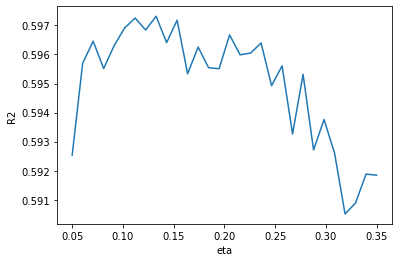

In [11]:
etas = np.linspace(0.05, 0.35, 30)
scores_eta=[]
for eta in etas:
    model = XGBRegressor(eta=eta)
    model.fit(X=X_train,y=y_train)
    score = model.score(X=X_test,y=y_test)
    scores_eta.append(score)

best_eta = round(etas[scores_eta.index(max(scores_eta))],3)
print('Best eta: ', best_eta)

sns.lineplot(x=etas, y=scores_eta)
plt.xlabel('eta')
plt.ylabel('R2');

Best max depth:  6


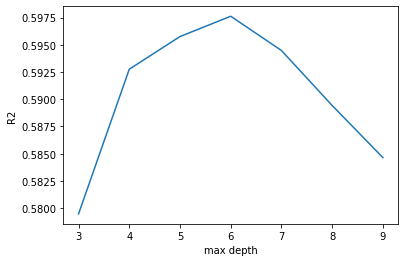

In [12]:
depths = np.arange(3,  10)
scores_depth=[]
for depth in depths:
    model = XGBRegressor(max_depth=depth, eta=best_eta)
    model.fit(X=X_train,y=y_train)
    score = model.score(X=X_test,y=y_test)
    scores_depth.append(score)

best_depth = round(depths[scores_depth.index(max(scores_depth))],3)
print('Best max depth: ', best_depth)

sns.lineplot(x=depths, y=scores_depth)
plt.xlabel('max depth')
plt.ylabel('R2');

Best gamma:  1.947


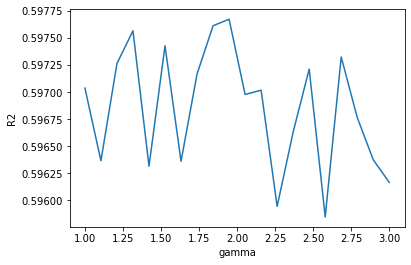

In [13]:
gammas = np.linspace(1,  3, num=20)
scores_gamma=[]
for gamma in gammas:
    model = XGBRegressor(gamma=gamma, eta=best_eta, max_depth=best_depth)
    model.fit(X=X_train,y=y_train)
    score = model.score(X=X_test,y=y_test)
    scores_gamma.append(score)

best_gamma = round(gammas[scores_gamma.index(max(scores_gamma))],3)
print('Best gamma: ', best_gamma)

sns.lineplot(x=gammas, y=scores_gamma)
plt.xlabel('gamma')
plt.ylabel('R2');

In [14]:
model = XGBRegressor(gamma=best_gamma, eta=best_eta, max_depth=best_depth)
model.fit(X=X_train, y=y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
residuals_test=y_test_pred-y_test
r_residuals_test=(y_test_pred-y_test)/y_test*100

In [15]:
print('Train: RMSE=', np.sqrt(mean_squared_error(y_train, y_train_pred)).round(3),
    ' R2=', r2_score(y_train, y_train_pred).round(3))

print('Test: RMSE=', np.sqrt(mean_squared_error(y_test, y_test_pred)).round(3),
    ' R2=', r2_score(y_test, y_test_pred).round(3))

Train: RMSE= 1.465  R2= 0.601
Test: RMSE= 1.48  R2= 0.597


## GridSearchCV

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
model = XGBRegressor(gamma=best_gamma, eta=best_eta, max_depth=best_depth)
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
grid = {
        'min_child_weight': [3, 4, 5],
        #'subsample': [0.3, 0.5, 1.0], # best 1 (default)
        'colsample_bytree': [0.7, 0.8, 0.9],
        #'alpha': [0, 0.5, 1], # best 1 (default)
        #'lambda' : [1, 5, 10], # best 1 (default)
        'learning_rate': [0.05, 0.1, 0.2]
         }
search = GridSearchCV(model, grid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
results = search.fit(X=X_train,y=y_train)
results.best_params_

{'colsample_bytree': 0.7, 'learning_rate': 0.2, 'min_child_weight': 5}

In [17]:
best_model=results.best_estimator_
best_model

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False, eta=0.133,
             eval_metric=None, gamma=1.947, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=5,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)

In [18]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
residuals_test=y_test_pred-y_test
r_residuals_test=(y_test_pred-y_test)/y_test*100

In [19]:
print('Train: RMSE=', np.sqrt(mean_squared_error(y_train, y_train_pred)).round(3),
    ' R2=', r2_score(y_train, y_train_pred).round(3))

print('Test: RMSE=', np.sqrt(mean_squared_error(y_test, y_test_pred)).round(3),
    ' R2=', r2_score(y_test, y_test_pred).round(3))

Train: RMSE= 1.487  R2= 0.589
Test: RMSE= 1.485  R2= 0.594


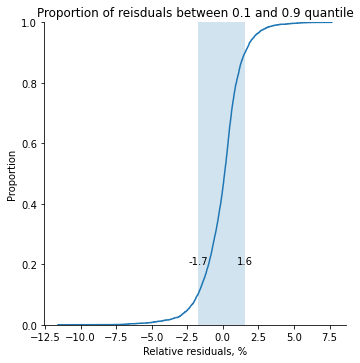

In [20]:
x1=np.quantile(residuals_test, 0.10)
x2=np.quantile(residuals_test, 0.90)
sns.displot(residuals_test, kind='ecdf',)
plt.xlabel('Residuals')
plt.fill_betweenx(y=[0,1], x1=x1, x2=x2, alpha=0.2)
plt.text(x=x1, y=0.2, s=x1.round(1), ha='center')
plt.text(x=x2, y=0.2, s=x2.round(1), ha='center')
plt.title('Proportion of reisduals between 0.1 and 0.9 quantile');

## Feature importance
https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27

https://mljar.com/blog/feature-importance-xgboost/


### XGBoost

In [21]:
importances = pd.DataFrame({'importance': best_model.feature_importances_ }, index=best_model.feature_names_in_ )
importances.sort_values('importance', ascending=False)

,importance
education_ord,0.376006
esize_class_ord,0.277834
lpk_3,0.227802
gender_M,0.078668
age_class_ord,0.039690


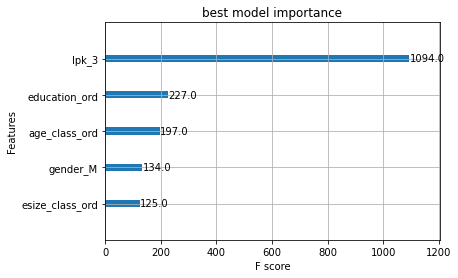

In [22]:
from xgboost import plot_importance
plot_importance(best_model)
plt.title("best model importance");

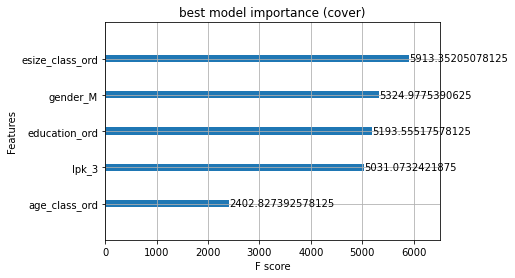

In [23]:
from xgboost import plot_importance
plot_importance(best_model, importance_type="cover")
plt.title("best model importance (cover)");

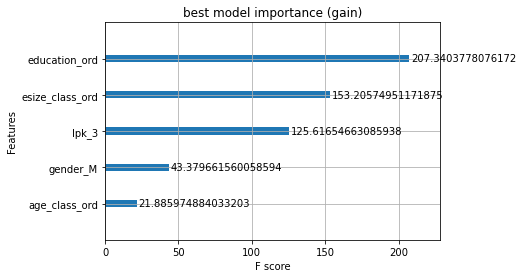

In [24]:
from xgboost import plot_importance
plot_importance(best_model, importance_type="gain")
plt.title("best model importance (gain)");

### SHAP

In [25]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


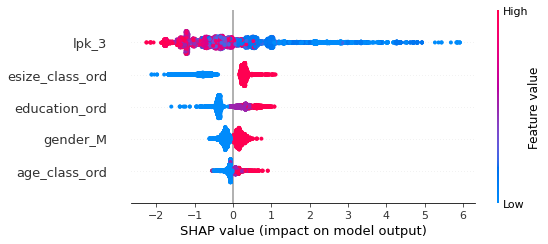

In [26]:
shap.summary_plot(shap_values);

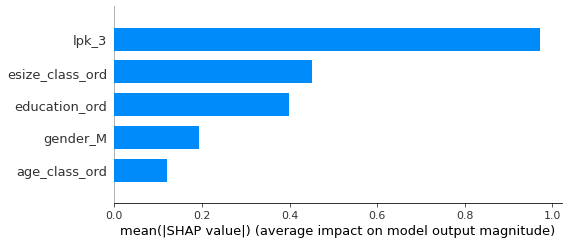

In [27]:
shap.summary_plot(shap_values, plot_type="bar");

In [28]:
shap_values = shap.TreeExplainer(best_model).shap_values(X_test)

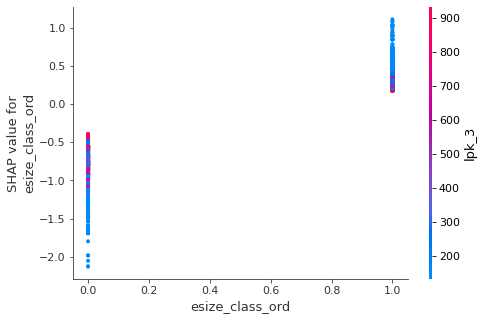

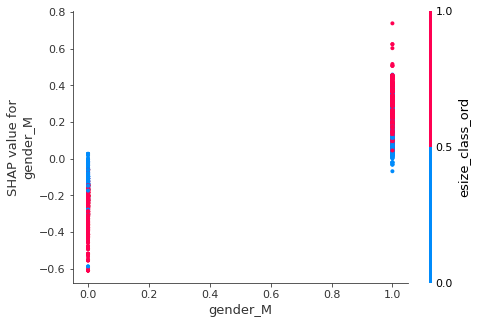

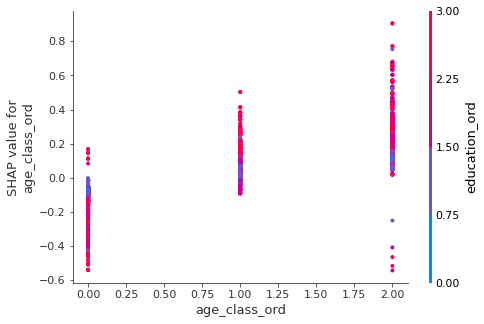

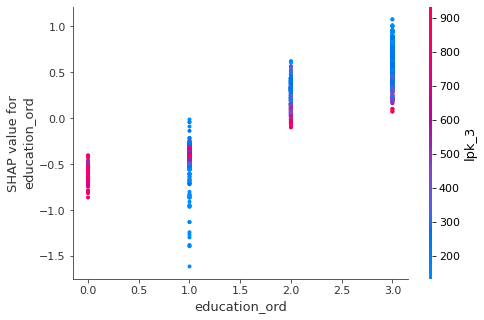

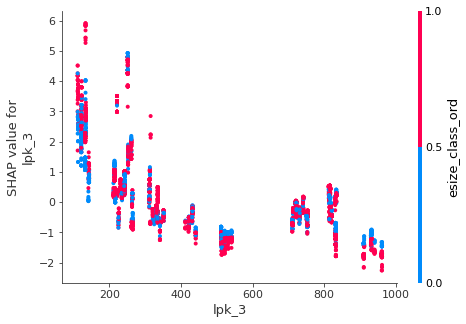

In [29]:
for feature in X_test.columns:
    shap.dependence_plot(feature, shap_values, X_test)    